In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from wordcloud import WordCloud
import mlflow
import os

In [ ]:
# Chargement des données
df = pd.read_csv("data/train_df.csv")

Distribution de la variable cible :
target
0    6419
1    6381
Name: count, dtype: int64


In [29]:

# Préparation des données
df = df.dropna(subset=['words'])
X = df['words']
y = df['target']

# Division des données
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
X_train, X_test = df_train['words'], df_test['words']
y_train, y_test = df_train['target'], df_test['target']


In [30]:
# Pipeline avec TF-IDF et Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression(max_iter=1000))
])

In [31]:
# Recherche des hyperparamètres
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'model__C': [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_weighted', cv=5, verbose=2, n_jobs=-1)


2025/01/16 16:22:38 INFO mlflow.tracking.fluent: Experiment with name 'text_classification_experiment' does not exist. Creating a new experiment.


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs hyperparamètres : {'model__C': 1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 1)}
Meilleur score F1 (validation) : 0.728158185206242


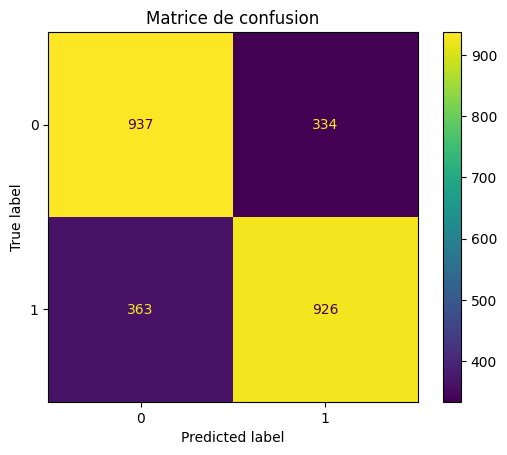

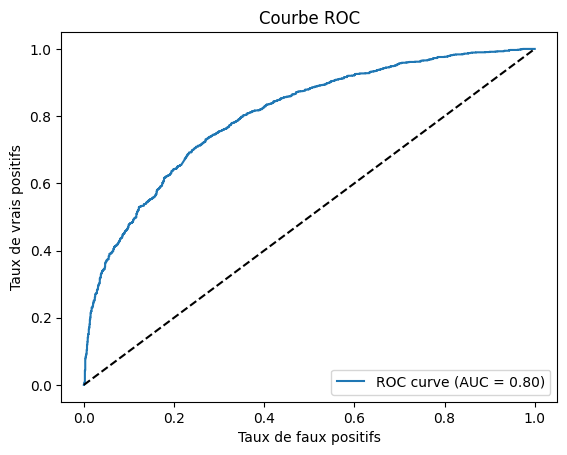

2025/01/16 16:23:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [32]:
# Initialisation de MLflow
mlflow.set_experiment("text_classification_experiment")
with mlflow.start_run():
    # Exécution de la recherche d'hyperparamètres
    grid_search.fit(X_train, y_train)

    # Enregistrement des paramètres et métriques
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("best_f1_score", grid_search.best_score_)

    # Meilleurs résultats
    print("Meilleurs hyperparamètres :", grid_search.best_params_)
    print("Meilleur score F1 (validation) :", grid_search.best_score_)

    # Évaluation sur les données de test
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Matrice de confusion")
    plt.show()

    # Courbe ROC
    probs = grid_search.best_estimator_.predict_proba(X_test)
    roc_auc = auc(*roc_curve(y_test, probs[:, 1])[:2])
    plt.figure()
    plt.plot(*roc_curve(y_test, probs[:, 1])[:2], label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("Courbe ROC")
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.legend(loc="lower right")
    plt.show()

    # Enregistrement des métriques supplémentaires
    mlflow.log_metric("roc_auc_tfidf", roc_auc)

    # Sauvegarde des résultats
    results_path = "./results/"
    os.makedirs(results_path, exist_ok=True)
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df.to_csv(os.path.join(results_path, "grid_search_results.csv"), index=False)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")